In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import tensorflow as tf
import seaborn as sns
import itertools
import random

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, BatchNormalization, Input, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
class LSTMAutoencoderAnomalyDetector:
    def __init__(self, 
                 sequence_length=15, 
                 n_layers=1, 
                 units=64, 
                 activation='tanh', 
                 dropout_rate = 0.0,
                 learning_rate=0.001,
                 batch_size=32,
                 epochs=100,
                 patience=10,
                 threshold_percentile=95,
                 scaler=None):
        self.sequence_length = sequence_length
        self.n_layers = n_layers
        self.units = units
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.threshold_percentile = threshold_percentile
        self.scaler = scaler if scaler else StandardScaler()
        self.model = None
        self.history = None
        self.thresholds_per_feature = None
        self.train_data = None
        self.test_data = None
        self.train_size = None
        self.n_features = None
        self.X_train = None
        self.X_test = None
        self.anomalies = None

    def preprocess_data(self, data, train_size=0.8):
        
        self.train_size = int(len(data) * train_size)
        self.train_data = data.iloc[:self.train_size]
        self.test_data = data.iloc[self.train_size:]
        
        self.train_scaled = self.scaler.fit_transform(self.train_data)
        self.test_scaled = self.scaler.transform(self.test_data)

        self.X_train = self._create_sequences(self.train_scaled)
        self.X_test = self._create_sequences(self.test_scaled)
        
        self.n_features = self.X_train.shape[2]
        print(f'Data preprocessed: {self.X_train.shape[0]} training sequences, {self.X_test.shape[0]} test sequences.')

    def _create_sequences(self, data):
        sequences = []
        for i in range(len(data) - self.sequence_length):
            seq = data[i:i + self.sequence_length]
            sequences.append(seq)
        return np.array(sequences)

    def build_model(self):
        inputs = Input(shape=(self.sequence_length, self.n_features))
        x = inputs
        # Encoder
        for i in range(self.n_layers):
            return_sequences = (i < self.n_layers - 1)
            x = LSTM(self.units, activation=self.activation, return_sequences=return_sequences)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        encoded = x
        # Decoder
        x = RepeatVector(self.sequence_length)(encoded)
        for i in range(self.n_layers):
            x = LSTM(self.units, activation=self.activation, return_sequences=True)(x)
            if self.dropout_rate > 0:
                x = Dropout(self.dropout_rate)(x)
        outputs = TimeDistributed(Dense(self.n_features))(x)
        self.model = Model(inputs, outputs)
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='mae')
        print('Model built successfully.')

    def train_model(self):
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=int(self.patience / 2), min_lr=1e-6)
        self.history = self.model.fit(
            self.X_train, self.X_train,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        print('Model trained successfully.')

    def evaluate_model(self):
        X_train_pred = self.model.predict(self.X_train)
        train_errors = np.mean(np.abs(self.X_train - X_train_pred), axis=1)

        self.thresholds_per_feature = np.percentile(train_errors, self.threshold_percentile, axis=0)
        
        X_test_pred = self.model.predict(self.X_test)
        test_errors = np.mean(np.abs(self.X_test - X_test_pred), axis=1)
        
        self.anomalies = test_errors > self.thresholds_per_feature
        self.X_test_pred = X_test_pred
        print('Model evaluation completed.')

    def plot_train_loss(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def get_anomaly_dataframe(self):
        num_test_sequences = self.X_test.shape[0]
        sequence_indices = np.arange(num_test_sequences)
        data_indices = self.train_size + self.sequence_length + sequence_indices - 1
        test_dates = self.test_data.index[self.sequence_length:]
        
        anomaly_df = pd.DataFrame(self.anomalies, index=test_dates, columns=self.train_data.columns)
        anomaly_df = anomaly_df.astype(int)
        return anomaly_df

    def plot_anomalies(self):
        anomaly_df = self.get_anomaly_dataframe()
        num_features = self.n_features
        ncols = 3
        nrows = int(np.ceil(num_features / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))
        fig.tight_layout(pad=3.0)
        fig.subplots_adjust(top=0.92)
        axes = axes.flatten()
        
        for i, feature in enumerate(self.train_data.columns):
            ax = axes[i]

            feature_test_data = self.test_data[feature].iloc[self.sequence_length:]
            feature_test_dates = feature_test_data.index
            ax.plot(feature_test_dates, feature_test_data.values, label='Test Data')

            anomalies = anomaly_df[feature]
            anomaly_dates = anomalies[anomalies == 1].index
            anomaly_values = self.test_data.loc[anomaly_dates, feature]
            ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
            ax.set_title(f'Feature: {feature}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Value')
            ax.legend()
        
        if len(axes) > num_features:
            for j in range(num_features, len(axes)):
                fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()

    def plot_random_sequence(self):
        num_sequences_to_plot = 1
        random_indices = random.sample(range(self.X_test.shape[0]), num_sequences_to_plot)

        for idx in random_indices:
            plt.figure(figsize=(15, 5))
            for feature in range(self.X_test.shape[2]):
                plt.plot(self.X_test[idx, :, feature], label=f'Actual Feature {feature}')
                plt.plot(self.X_test_pred[idx, :, feature], linestyle='--', label=f'Reconstructed Feature {feature}')
            plt.title(f'Sequence {idx} - Actual vs. Reconstructed')
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.legend()
            plt.show()

    def grid_search(self, param_grid):
        import itertools

        param_list = list(itertools.product(
            param_grid['num_layers'],
            param_grid['units'],
            param_grid['dropout_rate'],
            param_grid['learning_rate'],
            param_grid['batch_size']
        ))

        results = []

        for params in param_list:
            num_layers, units, dropout_rate, learning_rate, batch_size = params
            print(f'Training model with params: num_layers={num_layers}, units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}')

            self.build_model(num_layers=num_layers, units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)

            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            self.history = self.model.fit(
                self.X_train, self.X_train,
                epochs=50,
                batch_size=batch_size,
                validation_split=0.1,
                shuffle=False,
                callbacks=[early_stopping],
                verbose=0
            )

            val_indices = int(len(self.X_train) * 0.9)
            X_val = self.X_train[val_indices:]
            X_val_pred = self.model.predict(X_val)
            val_mae = np.mean(np.abs(X_val - X_val_pred))

            results.append({
                'num_layers': num_layers,
                'units': units,
                'dropout_rate': dropout_rate,
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'val_mae': val_mae
            })

            print(f'Validation MAE: {val_mae}')

        results_df = pd.DataFrame(results)

        best_model_params = results_df.loc[results_df['val_mae'].idxmin()]
        print('\nBest Model Parameters:')
        print(best_model_params)

        self.build_model(
            num_layers=int(best_model_params['num_layers']),
            units=int(best_model_params['units']),
            dropout_rate=best_model_params['dropout_rate'],
            learning_rate=best_model_params['learning_rate']
        )
        self.train_model(
            epochs=100,
            batch_size=int(best_model_params['batch_size']),
            validation_split=0.1
        )

        return results_df

Original Dataset


In [59]:
df = pd.read_csv('mid_cap_all_sectors_ret.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

In [60]:
lstm_detector = LSTMAutoencoderAnomalyDetector()
lstm_detector.preprocess_data(df)
lstm_detector.build_model()
lstm_detector.train_model()

Data preprocessed: 4948 training sequences, 1226 test sequences.
Model built successfully.
Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.7050 - val_loss: 0.5312 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6841 - val_loss: 0.5226 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6708 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6621 - val_loss: 0.5148 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6579 - val_loss: 0.5129 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6545 - val_loss: 0.5102 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6498 - val_loss: 0.5077 - learning_rate: 0.0010
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6457 - val_loss: 0.5055 - learning_rate: 0.0010
Epoch 9/100
140/140 

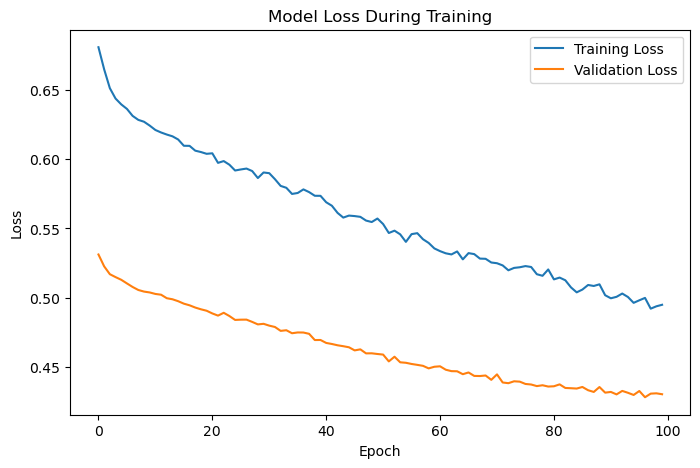

In [61]:
lstm_detector.plot_train_loss()

In [62]:
lstm_detector.evaluate_model()

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model evaluation completed.


In [63]:
anomaly_df = lstm_detector.get_anomaly_dataframe()

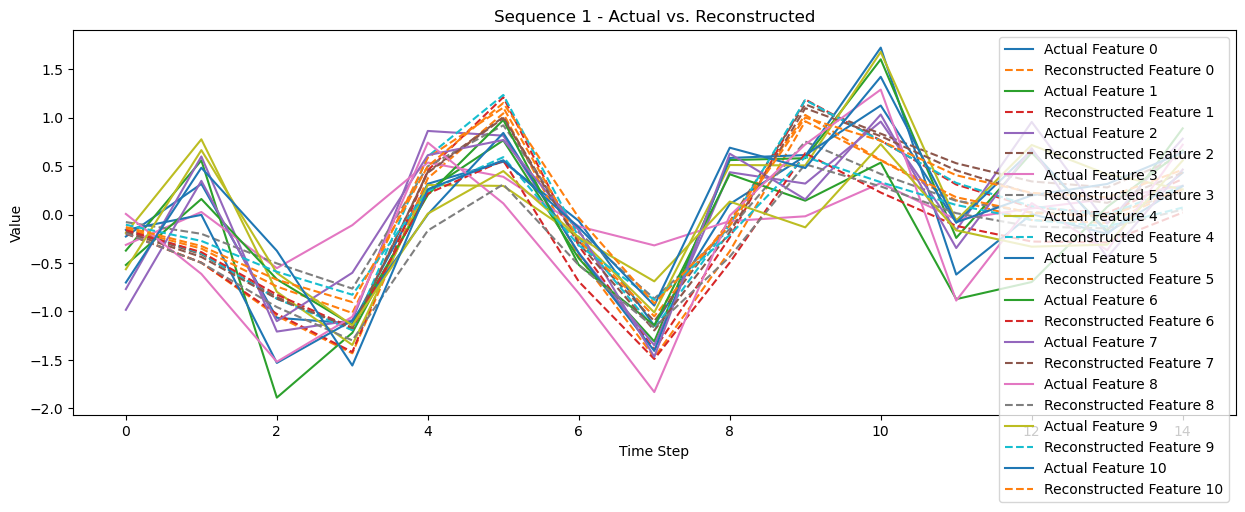

In [87]:
lstm_detector.plot_random_sequence()

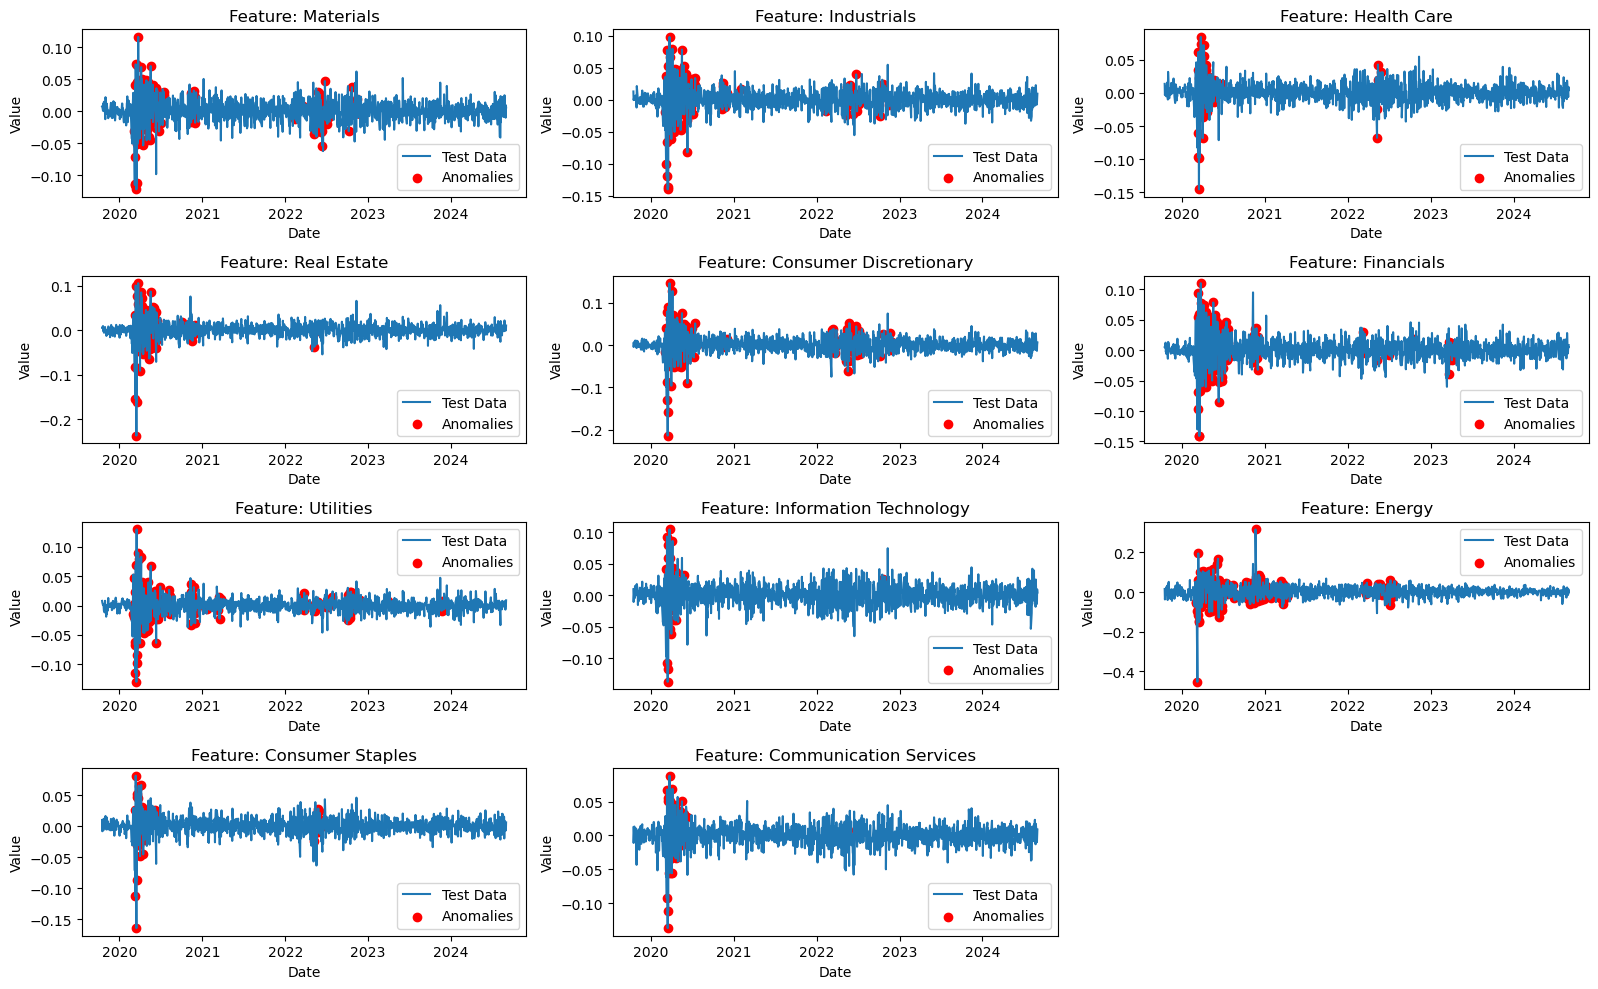

In [64]:
lstm_detector.plot_anomalies()

Dataset w/ 2008 removed

In [65]:
start_date = '2008-08-01'
end_date = '2009-04-01'

new_df = df[~((df.index >= start_date) & (df.index <= end_date))]

print(f"Data after removing date range from {start_date} to {end_date}:")
print(new_df.index.min(), "to", new_df.index.max())

Data after removing date range from 2008-08-01 to 2009-04-01:
2000-01-04 00:00:00 to 2024-08-30 00:00:00


In [66]:
lstm_detector_new = LSTMAutoencoderAnomalyDetector()
lstm_detector_new.preprocess_data(new_df)
lstm_detector_new.build_model()
lstm_detector_new.train_model()

Data preprocessed: 4813 training sequences, 1193 test sequences.
Model built successfully.
Epoch 1/100


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7488 - val_loss: 0.6167 - learning_rate: 0.0010
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7287 - val_loss: 0.6069 - learning_rate: 0.0010
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7168 - val_loss: 0.5968 - learning_rate: 0.0010
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7049 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7007 - val_loss: 0.5931 - learning_rate: 0.0010
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6954 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6896 - val_loss: 0.5849 - learning_rate: 0.0010
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6861 - val_loss: 0.5838 - learning_rate: 0.0010
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6835 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 10/100


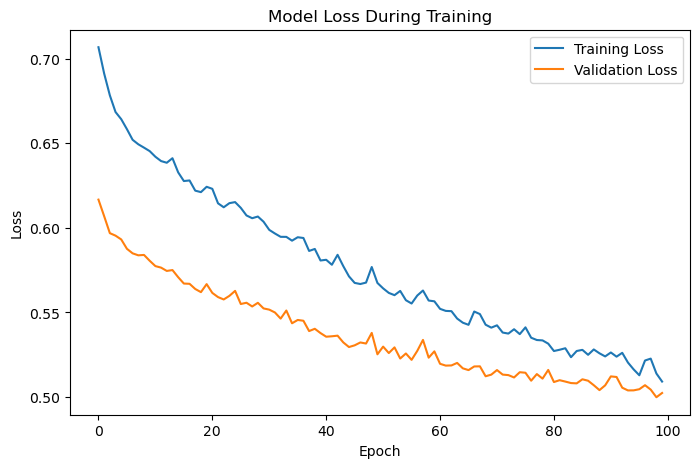

In [67]:
lstm_detector_new.plot_train_loss()

In [68]:
lstm_detector_new.evaluate_model()

151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model evaluation completed.


In [69]:
anomaly_df_new = lstm_detector_new.get_anomaly_dataframe()

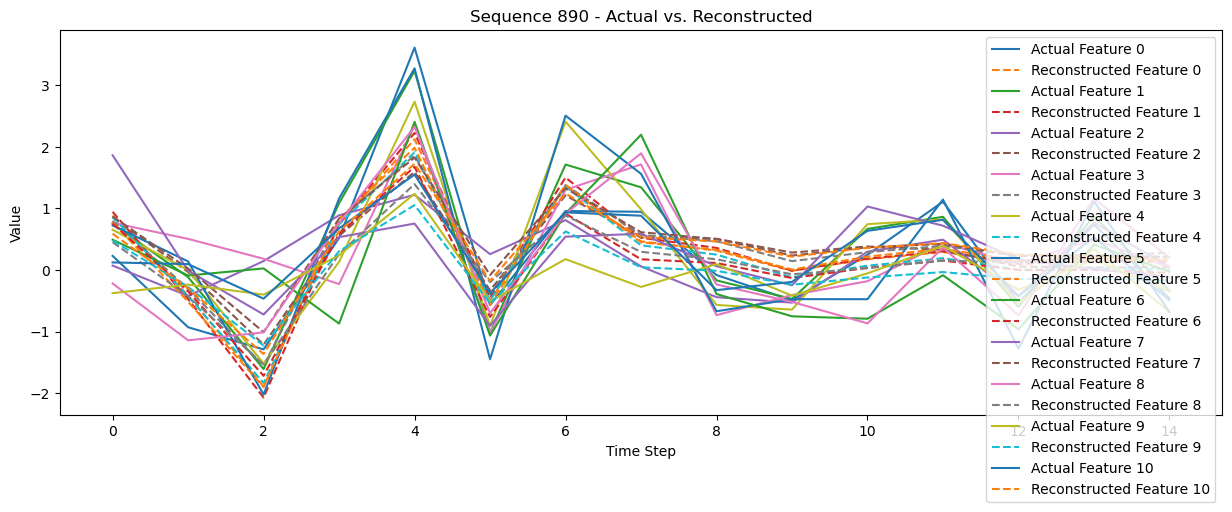

In [81]:
lstm_detector_new.plot_random_sequence()

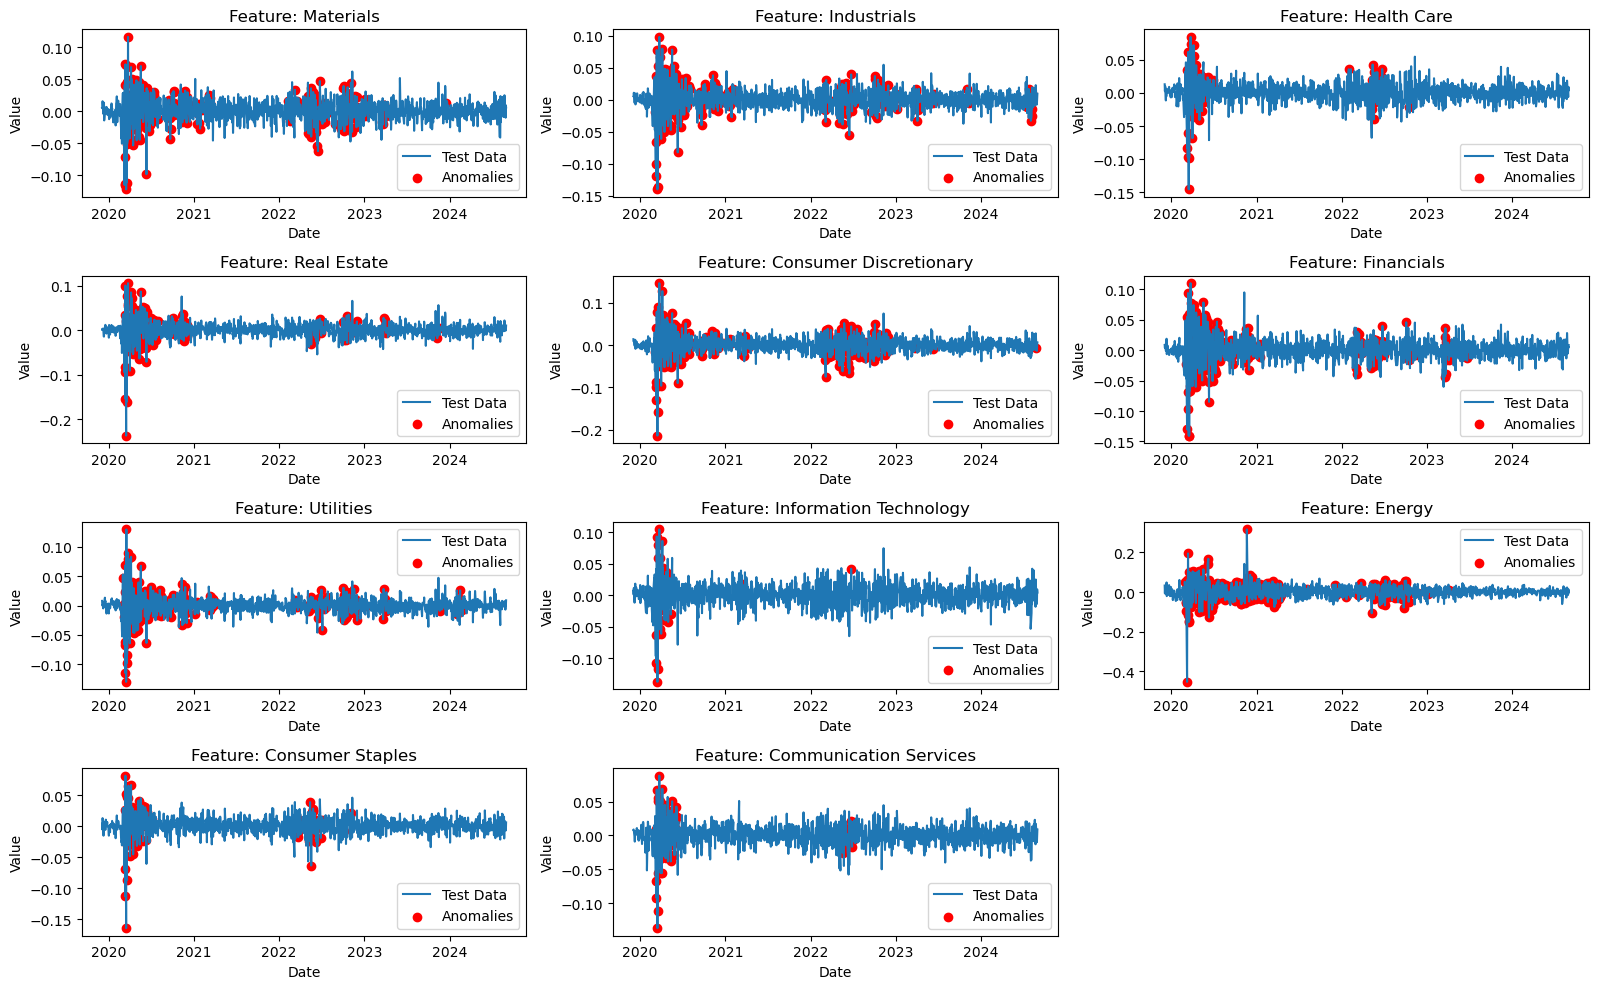

In [70]:
lstm_detector_new.plot_anomalies()